In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import numpy as np

In [ ]:
# Part 1: rRNA

In [212]:
# Read file in GFF format
def read_gff(path_to_gff):
    gff = pd.read_csv(path_to_gff, comment='#', sep='\t', header=None)
    header = ['Chromosome', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attribute']
    gff.columns = header[:len(gff.columns)]
    return gff

In [99]:
gff_df = read_gff('rrna_annotation.gff')

In [100]:
# Read file in BED format with six column
def read_bed6(path_to_bed):
    bed = pd.read_csv(path_to_bed, sep='\t', header=None)
    header = ['Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand']
    bed.columns = header[:len(bed.columns)]
    return bed

In [101]:
bed6_df = read_bed6('alignment.bed')

In [102]:
# Leave only rRNA type data
def simple_attribute(gff_df):
    gff_df['Attribute'] = gff_df['Attribute'].str.replace('Name=', '').str.replace('_r.+', '', regex=True)
    return gff_df

In [103]:
gff_simple = simple_attribute(gff_df)

In [104]:
# Creating a table counting each rRNA type by chromosome
def count_type_of_rna(gff_df):
    return gff_df.groupby(['Chromosome', 'Attribute']).size().reset_index(name='Counts')

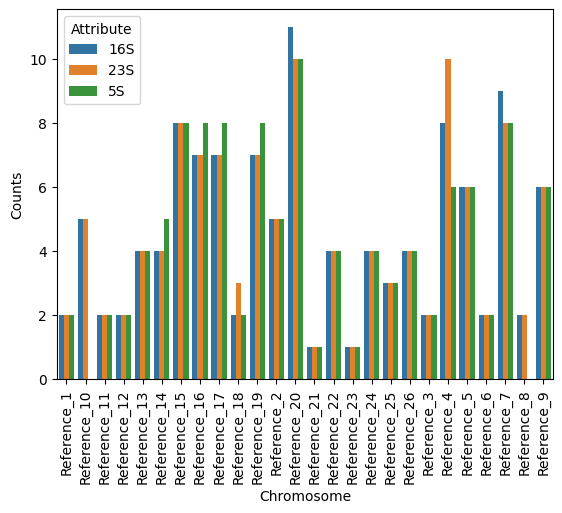

In [105]:
# Creating bar plot
gff_rna_table = count_type_of_rna(gff_simple)
sns.barplot(data=gff_rna_table, x='Chromosome', y='Counts', hue='Attribute')
plt.xticks(rotation=90);

In [106]:
# Intersection of rRNA and contig interval
gff_bed6_merge = pd.merge(gff_simple, bed6_df, on='Chromosome', how='outer')
gff_bed6_merge = gff_bed6_merge[(gff_bed6_merge['Start_x'] >= gff_bed6_merge['Start_y']) & (gff_bed6_merge['End_x'] <= gff_bed6_merge['End_y'])]
gff_bed6_merge

          Chromosome       Source  Type  Start_x    End_x       Score_x  \
129     Reference_11  barrnap:0.9  rRNA   924358   925855  0.000000e+00   
156     Reference_11  barrnap:0.9  rRNA   926697   929642  0.000000e+00   
183     Reference_11  barrnap:0.9  rRNA   929827   929936  1.400000e-12   
215     Reference_11  barrnap:0.9  rRNA  2074460  2075957  0.000000e+00   
242     Reference_11  barrnap:0.9  rRNA  2076799  2079744  0.000000e+00   
...              ...          ...   ...      ...      ...           ...   
121855  Reference_14  barrnap:0.9  rRNA  2433040  2433152  2.000000e-12   
122182  Reference_14  barrnap:0.9  rRNA  3766952  3767064  2.000000e-12   
122583  Reference_25  barrnap:0.9  rRNA  1329370  1329473  2.900000e-10   
125060  Reference_25  barrnap:0.9  rRNA  1822913  1823016  2.900000e-10   
125776  Reference_25  barrnap:0.9  rRNA  3744056  3744159  2.900000e-10   

       Strand_x Phase Attribute  Start_y    End_y  \
129           +     .       16S   923529   930

In [ ]:
# Part 1: volcano polt

In [197]:
# Read file with differential gene expression
diff_expr = pd.read_table('diffexpr_data.tsv.gz')

# Division of the dataset into four groups according to the level of significance and change in expression
def grouper(p, change):
    if change >= 0:
        if p < 0.05:
            return 'Significantly upregulated'
        else:
            return 'Non-significantly upregulated'
    else:
        if p < 0.05:
            return 'Significantly downregulated'
        else:
            return 'Non-significantly downregulated'


# Creating a new column
diff_expr['Groups'] = diff_expr.apply(lambda x: grouper(x.pval_corr, x.logFC), axis=1)

# Finding the top 2 genes that have significantly decreased expression
sign_down = diff_expr[diff_expr['Groups'] == 'Significantly downregulated']
sign_down = sign_down.sort_values(by='logFC')

# Finding the top 2 genes that significantly increased expression
sign_up = diff_expr[diff_expr['Groups'] == 'Significantly upregulated']
sign_up = sign_up.sort_values(by='logFC', ascending=False)

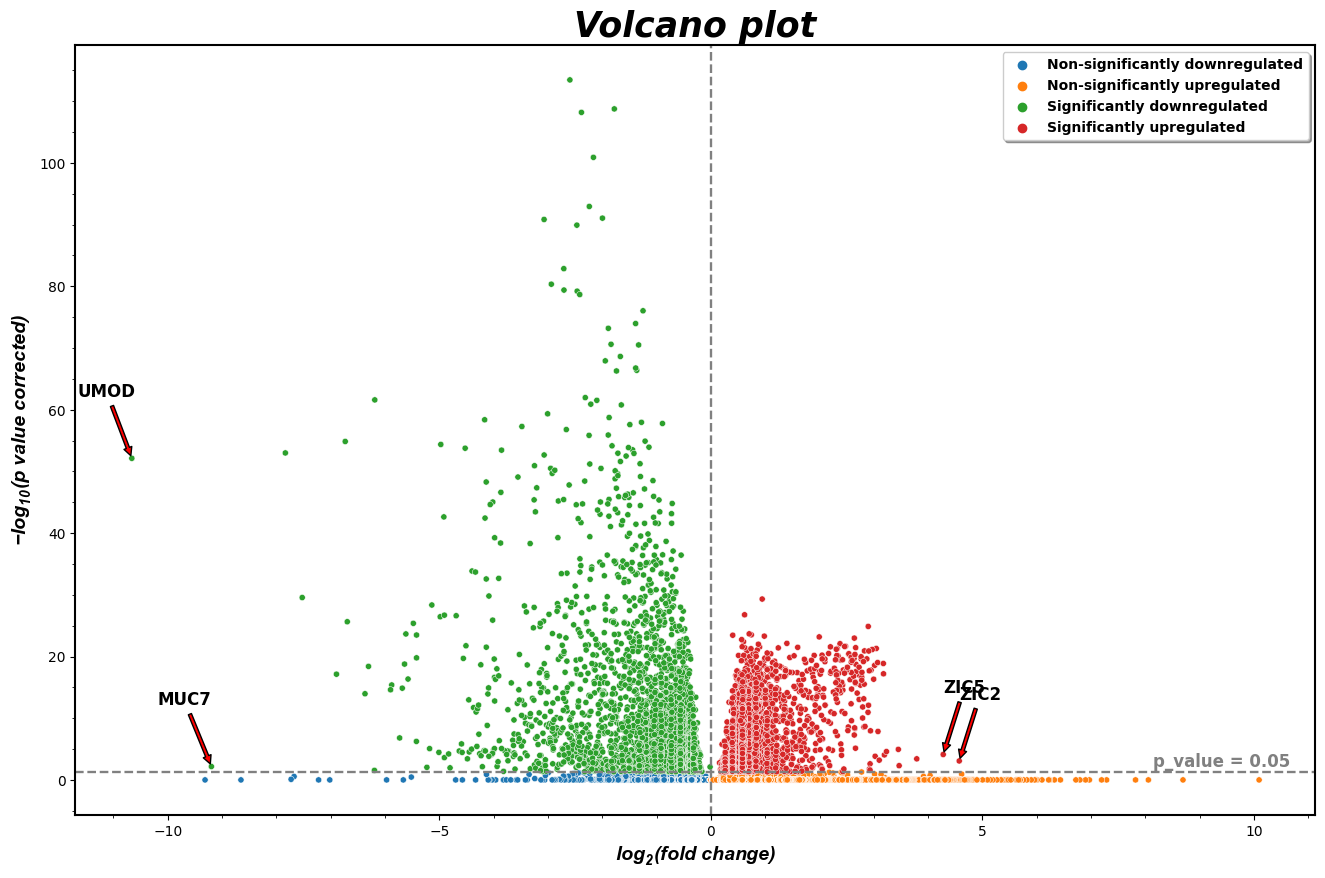

In [217]:
# Creating a volcano-plot
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=diff_expr.sort_values('Groups'), x='logFC', y='log_pval', hue='Groups', s=20)

# Separating segments with dashed lines
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1.68)
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--', linewidth=1.68)

# The caption "p_value = 0.05" above the corresponding line
ax.annotate('p_value = 0.05', xy=(830, 80), xycoords='figure points',
            color='grey', weight='bold', size=12)

# Axis captions and title in bold italics
plt.title('Volcano plot', weight='bold', style='italic', size=25)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:italic:bold'

plt.xlabel(r'$\mathbf{\bf{log_2(fold\ change)}}$', size=14)
plt.ylabel(r"$\mathbf{-log_{10}(p \ value \ corrected)}$", size=14)

# Display of ticks and minor ticks
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

# Symmetric limits for the X-axis
x_min = round(diff_expr['logFC'].min(), 1) - 1
x_max = round(diff_expr['logFC'].max(), 1) + 2

# Axle thickness
for axis in ['top', 'bottom', 'right', 'left']:
    fig.gca().spines[axis].set_linewidth(1.5)

# Legend (letter size and font, marker size, shadow)
plt.legend(shadow=True, prop={'weight':'bold'})

# Top 2 genes that significantly decreased and increased expression with arrows
ax.annotate(sign_up.iloc[0][0],
            xy=(sign_up.iloc[0][1], sign_up.iloc[0][4]),
            xytext=(sign_up.iloc[0][1], sign_up.iloc[0][4] + 10),
            arrowprops=dict(arrowstyle='simple', facecolor='red'), weight='semibold', size=12
            )

ax.annotate(sign_up.iloc[1][0],
            xy=(sign_up.iloc[1][1], sign_up.iloc[1][4]),
            xytext=(sign_up.iloc[1][1], sign_up.iloc[1][4] + 10),
            arrowprops=dict(arrowstyle='simple', facecolor='red'), weight='semibold', size=12
            )

ax.annotate(sign_down.iloc[0][0],
            xy=(sign_down.iloc[0][1], sign_down.iloc[0][4]),
            xytext=(sign_down.iloc[0][1]-1, sign_down.iloc[0][4] + 10),
            arrowprops=dict(arrowstyle='simple', facecolor='red'), weight='semibold', size=12
            )

ax.annotate(sign_down.iloc[1][0],
            xy=(sign_down.iloc[1][1], sign_down.iloc[1][4]),
            xytext=(sign_down.iloc[1][1]-1, sign_down.iloc[1][4] + 10),
            arrowprops=dict(arrowstyle='simple', facecolor='red'), weight='semibold', size=12
            );